Librerias

In [15]:
using SymPy
using Interpolations
using Plots

Datos de temperaturas por Dia

In [16]:
dias = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
temperaturas = [23.0, 24.0, 25.0, 26.0, 27.0, 22.0, 23.0]

7-element Vector{Float64}:
 23.0
 24.0
 25.0
 26.0
 27.0
 22.0
 23.0

Interpolación de Taylor

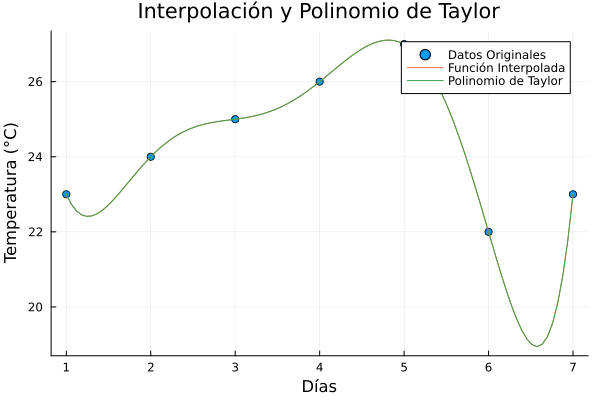

In [17]:
#Polinomio de Taylor
# Interpolación lineal
funcion_original = LinearInterpolation(dias, temperaturas)

# Definir la variable simbólica x
x = symbols("x")

# Construir la función interpolada
func_interp = 0
for dia in dias
    term = funcion_original[dia]
    for d in dias
        if d != dia
            term *= (x - d) / (dia - d)
        end
    end
    func_interp += term
end

# Parámetros para el polinomio de Taylor
punto = 7
grado_taylor = 7       
n_taylor = grado_taylor + 1  

# Calcular el polinomio de Taylor
polinomio_taylor = 0
for k in 0:n_taylor-1
    derivada_k = diff(func_interp, x, k)
    derivada_punto = subs(derivada_k, x, punto)
    termino_k = (derivada_punto/factorial(k)) * (x - punto)^k
    polinomio_taylor += termino_k
end

# Imprimir el polinomio de Taylor
#println("Polinomio de Taylor de grado $grado_taylor alrededor de x = $punto:", polinomio_taylor)

# Crear funciones para evaluar
func_interp_eval = lambdify(func_interp, [x])
polinomio_taylor_eval = lambdify(polinomio_taylor, [x])

# Crear datos para graficar
x_vals = range(minimum(dias), maximum(dias), length=100)
y_vals_interp = func_interp_eval.(x_vals)
y_vals_taylor = polinomio_taylor_eval.(x_vals)

# Graficar
plot(dias, temperaturas, seriestype=:scatter, label="Datos Originales", markershape=:circle)
plot!(x_vals, y_vals_interp, label="Función Interpolada")
plot!(x_vals, y_vals_taylor, label="Polinomio de Taylor")
xlabel!("Días")
ylabel!("Temperatura (°C)")
title!("Interpolación y Polinomio de Taylor")

Interpolación de Lagrange

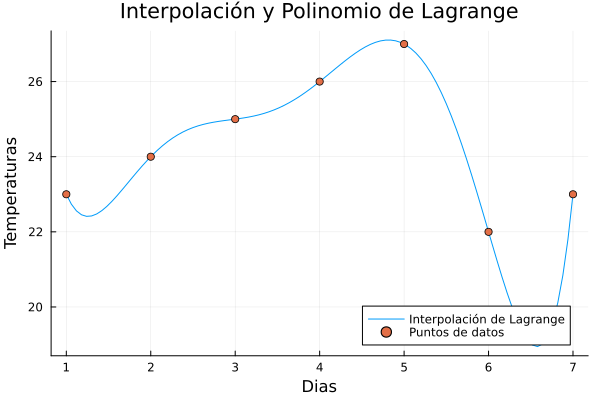

In [18]:
# Polinomio de Lagrange
n = length(dias)
x = symbols("x")
polinomio = 0
divisorL = zeros(Float64, n)

for i in 1:n
    # Termino de Lagrange
    numerador = 1
    denominador = 1

    for j in 1:n
        if j != i
            numerador *= (x - dias[j])
            denominador *= (dias[i] - dias[j])
        end
    end

    terminoLi = numerador / denominador
    polinomio += terminoLi * temperaturas[i]
    divisorL[i] = denominador
end


# Simplificación del polinomio
polisimple = simplify(polinomio)

# Evaluación numérica
px = lambdify(polinomio, [x])

# Puntos para la gráfica
muestras = 101
a = minimum(dias)
b = maximum(dias)
pdias = range(a, b, length=muestras)
ptemperaturas = px.(pdias)

#println("Temperatura en x = 8 según la función original:", px(8))
# Salida
#println("    valores de temperaturas: ", temperaturas)
#println("divisores en L(i): ", divisorL)
#println()
#println("Polinomio de Lagrange, expresiones")
#println(polinomio)
#println()
#println("Polinomio de Lagrange: ")
#println(polisimple)

# Gráfica
plot(pdias, ptemperaturas, xlabel="Dias", ylabel="Temperaturas", label="Interpolación de Lagrange")
scatter!(dias, temperaturas, label="Puntos de datos", legend=:bottomright)
title!("Interpolación y Polinomio de Lagrange")

Interpolación de Hermite

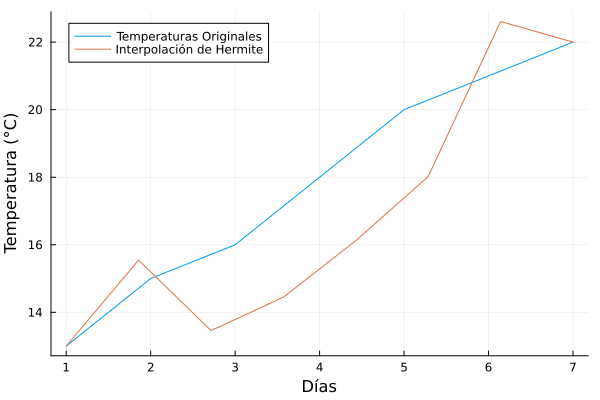

In [1]:
using SymPy
using Plots

# Generación de Datos
dias = [1, 2, 3, 4, 5, 6, 7]
temperaturas = [13, 15, 16, 18, 20, 21, 22]

# Graficar los datos originales
plot(dias, temperaturas, xlabel="Días", ylabel="Temperatura (°C)", label="Temperaturas Originales")

# Función para calcular derivadas usando diferencias finitas
function calcular_derivadas(x, y)
    n = length(x) # Obtener el número de puntos
    dy = zeros(n) # Crear un arreglo para almacenar las derivadas
    for i in 1:n-1 # Iterar sobre los puntos, excepto el último
        dy[i] = (y[i+1] - y[i]) / (x[i+1] - x[i]) # Calcular la derivada usando diferencias finitas
    end
    dy[n] = dy[n-1]  # Asumir la misma derivada para el último punto
    return dy 
end

# Calcular derivadas
derivadas = calcular_derivadas(dias, temperaturas)

# Función para calcular el punto de hermite en un punto dado "t" 
function hermite(puntoDado, nodos, funcion, funcion_derivada)

    # Almacenamos el número de nodos (puntos donde se intersectan las funciones y sus derivadas)
    numNodos = length(nodos)
    # Inicializamos el resultado de la interpolación Hermite en 0
    resultado = 0.0

    # Itera sobre cada nodo
    for i in 1:numNodos # Para i desde 1 hasta la cantidad de nodos (incluyéndolo)
        valorFuncion = funcion[i] # Guardamos el valor de la función en el nodo i
        valorDerivada = funcion_derivada[i] # Guardamos la derivada del valor de la función en el nodo i

        # Inicializar el polinomio de Lagrange y su derivada
        lagrange = 1.0
        lagrange_derivada = 0.0


        # Calculamos el polinomio de lagrange y su derivada (para el nodo i)
        for j in 1:numNodos
            if i != j

                #= 
                Actualizamos lagrange multiplicandolo por el factor correspondiente
                en función de la diferencia entre el punto de interpolación y el nodo actual
                =#
                lagrange *= (puntoDado - nodos[j]) / (nodos[i] - nodos[j])

                #=
                Actualizamos la derivada del polinomio de lagrange sumandolo con la inversa
                de la diferencia entre el nodo de iteracion y el nodo actual
                =#
                lagrange_derivada += 1 / (nodos[i] - nodos[j])
            end
        end


        #= 
        Multiplicamos la derivada de lagrange por la lagrange calculada 
        para obtener una expresión que tenga en cuenta tanto los valores de la 
        función como sus derivadas en el nodo i
        =#
        lagrange_derivada *= lagrange

        # Aplicamos la fórmula de Hermite 
        resultado += valorFuncion * lagrange^2 * (1 - 2 * (puntoDado - nodos[i]) * lagrange_derivada) + valorDerivada * lagrange^2 * (puntoDado - nodos[i])
    end
    return resultado
end

# Evaluar la interpolación
dias_interpolados = range(dias[1], stop=dias[end], length=8)
temperaturas_interpoladas = [hermite(d, dias, temperaturas, derivadas) for d in dias_interpolados]

# Graficar la interpolación de Hermite
# plot! para añadir una nueva barra de gráfica y ver tanto la de Hermites como la de los datos originales
plot!(dias_interpolados, temperaturas_interpoladas, label="Interpolación de Hermite")